# Calibrazione della camera
La calibrazione della camera è un processo fondamentale che viene eseguito nei sistemi di visione di misura industriale basati su matrici di pixel, come ad esempio le telecamere CCD o CMOS, in questo caso verrà utilizzato un sensore CMOS da 24MP. Questa procedura viene effettuata al fine di garantire la massima accuratezza e precisione nelle misurazioni geometriche degli oggetti in esame.

In particolare, la calibrazione della camera si basa sulla determinazione dei parametri intrinseci e estrinseci che caratterizzano la geometria della telecamera e la sua posizione nello spazio rispetto all'oggetto da misurare. I parametri intrinseci includono:

* La lunghezza focale, che determina il rapporto tra la distanza dell'oggetto dalla lente della telecamera e la sua dimensione apparente sull'immagine;
* La distorsione geometrica, che causa una deformazione delle immagini a causa dell'effetto di curvatura dei raggi luminosi sulla superficie della matrice dei pixel.

I parametri estrinseci, invece, riguardano la posizione e l'orientamento della telecamera nello spazio, che vengono descritti tramite una matrice di rotazione e un vettore di traslazione.

La calibrazione della camera viene eseguita mediante l'utilizzo di un opportuno pattern geometrico, costituito da punti distinti disposti in maniera nota nello spazio, chiamato master di taratura. Tramite la misura delle coordinate dei punti sul master dei pixel e le loro corrispondenti posizioni reali nello spazio, è possibile ricavare i parametri intrinseci ed estrinseci della telecamera tramite un'opportuna procedura di ottimizzazione.

Questo processo prevede l'acquisizione di un'immagine di un punto noto e l'ottenimento delle sue coordinate Xsg, Ysg, Zsg proiettate nel sistema Is, Js. Tuttavia, ci sono 11 incognite e solo 2 equazioni, con ogni punto che ha solo 2 coordinate. Per risolvere questo sistema, sono necessari almeno 6 punti diversi con coordinate Zsg diverse, il che si traduce in un totale di 12 equazioni.

Il recupero dei punti noti è basato sul master di taratura. Per l'asse X, vengono identificati i marcatori più grandi e si calcola la loro distanza reciproca per poter determinare i centri più distanti che formano l'asse x. Per l'asse Y, i centri meno distanti vengono utilizzati per formare l'asse y. Le coordinate globali sono determinate in base al centro del sistema globale nel centro del master di taratura.

Input del processo di calibrazione che dovrà inserire l'utente:
- nome e path dell'immagine
- soglia alta e bassa della correzzione del contrasto
- soglia binarizzazione
- numero target rige e colonne
- distanza dei centri del master di taratura in mm

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os

#INPUT
#Cartella dove sono contenute le immagini
IMGDIR = 'imm/'
#Nome ed estensione dell'immagine da elaborare
IMGNAME = 'Calibrazione_camera_vera.jpg'
#numero di target sulle righe
N=14
#numero di target sulle colonne
M=21
#distanza piano di riferimento dalla camera in mm
ZSGVero = 530 
#distanza in mm tra i cerchi della matrice di calibrazione
DISTANZAMM = 20
deltaX = DISTANZAMM #distanza tra i centri del target sull'asse x
deltaY = DISTANZAMM #distanza tra i centri del target sull'asse y
#Soglia alta e bassa del filtro di contrasto
thLow = 50
thHigh = 170
#Soglia per la binarizzazione
thLowBin = 20
thHighBin = 255
#per la calibrazione della lama di luce
# Distanza dal piano del master dalla telecamera in mm
I=np.array([480,490,500,510,520,530,540,550,560,570,580])
# Nome del file che precede la distanza
IMGNAMECALIB = 'Calibrazione_'

img = cv.imread(os.path.join( IMGDIR, IMGNAME), cv.IMREAD_COLOR )
assert img is not None, "ERROR: Immagine non trovata!"
h, w, _ = img.shape
print( f"Dimensione in pixel dell'immagine letta: {h, w}" )
rgb = cv.cvtColor( img, cv.COLOR_BGR2RGB ) 
gray = cv.cvtColor( img, cv.COLOR_BGR2GRAY ) 

Dimensione in pixel dell'immagine letta: (4000, 5820)


# Contrasto e binarizzazione
Regolando il contrasto, è possibile migliorare la visibilità e la distinguibilità dei marcatori utilizzati per la calibrazione, facilitandone l'identificazione e la localizzazione accurata. Ciò si traduce in misurazioni più precise e un numero inferiore di errori durante il processo di calibrazione.

La binarizzazione, invece, semplifica l'immagine convertendola in un formato binario con solo due colori o livelli di grigio. Ciò può aiutare ad eliminare il rumore di fondo e altre caratteristiche irrilevanti, consentendo una focalizzazione più chiara sui marcatori. Riducendo la complessità dell'immagine, la binarizzazione può anche accelerare i tempi di elaborazione richiesti per la calibrazione, rendendo il processo complessivamente più efficiente.

(-0.5, 5819.5, 3999.5, -0.5)

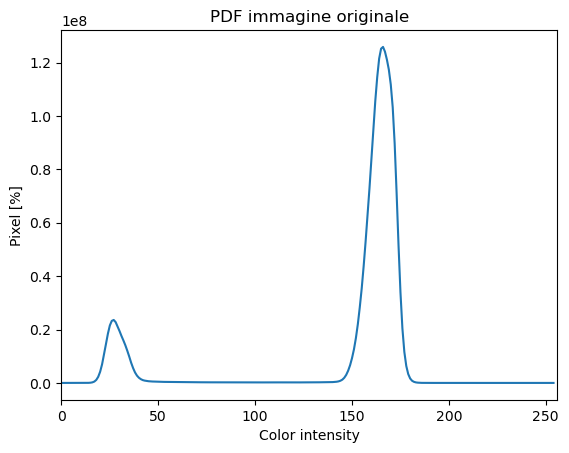

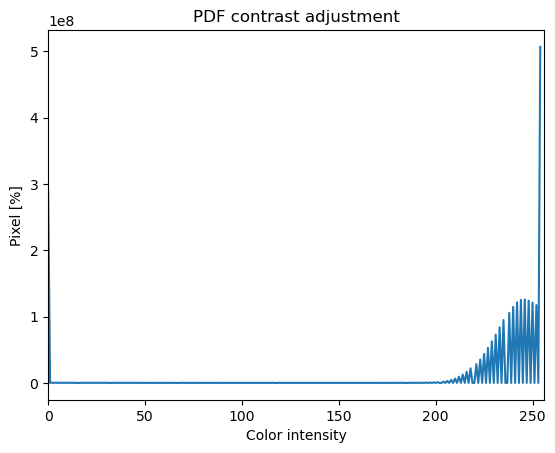

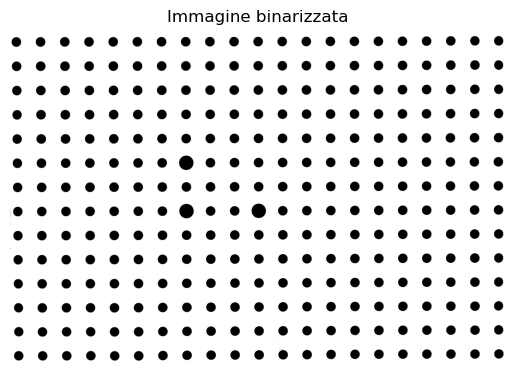

In [3]:
pdf = np.histogram( gray, bins=range(256) )[0]/1*100
#Plot histogram pdf
fig, ax = plt.subplots()
ax.plot( pdf )
ax.set_title( "PDF immagine originale" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

#eseguo un contrast adjustment 
def contrastAdjust( px, th_l, th_h ):
    if px < th_l:
        return 0
    if px >= th_h:
        return 255
    else:
        return 255*(px - th_l)/(th_h - th_l)

imgContrastAdjust = np.frompyfunc( lambda x: contrastAdjust(x, thLow, thHigh), 1, 1)
imgCA = imgContrastAdjust(gray).astype('uint8')

pdf2 = np.histogram( imgCA, bins=range(256) )[0]/1*100
fig, ax = plt.subplots()
ax.plot( pdf2 )
ax.set_title( "PDF contrast adjustment" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

#eseguo la binarizzazione dell'immagine
ret2, imgBIN = cv.threshold( imgCA, thLowBin, thHighBin, cv.THRESH_BINARY )
fig, ax = plt.subplots()
ax.imshow( imgBIN, cmap='gray' )
ax.set_title( "Immagine binarizzata" )
ax.axis('off')

# Ricerca dei target circolari
La funzione `HoughCircles` è una funzione della libreria OpenCV che viene utilizzata per rilevare i cerchi in un'immagine. Utilizza la trasformata di Hough per i cerchi, trovando sia il **centro che il loro raggio.**

Ecco come si usa:

```python
circles = cv2.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]])
```

Parametri:

- `image`: L'immagine in cui cercare i cerchi. Deve essere una immagine in scala di grigi.
- `method`: Il metodo di rilevamento da utilizzare. Attualmente, l'unico metodo implementato è `cv2.HOUGH_GRADIENT`.
- `dp`: Il rapporto inverso della risoluzione dell'accumulatore rispetto alla risoluzione dell'immagine.
- `minDist`: La distanza minima tra i centri dei cerchi rilevati.
- `circles` (opzionale): Un output vettore che memorizza i cerchi rilevati.
- `param1` (opzionale): Il primo parametro specifico del metodo. Nel caso di `cv2.HOUGH_GRADIENT`, è il limite superiore del due passaggi di soglia applicato nell'algoritmo di rilevamento dei bordi interno.
- `param2` (opzionale): Il secondo parametro specifico del metodo. Nel caso di `cv2.HOUGH_GRADIENT`, è il soglia dell'accumulatore per i centri dei cerchi. Più piccolo è, più cerchi falsi possono essere rilevati. I cerchi, corrispondenti ai maggiori accumulatore, saranno restituiti per primi.
- `minRadius` (opzionale): Il raggio minimo dei cerchi da rilevare.
- `maxRadius` (opzionale): Il raggio massimo dei cerchi da rilevare.

La funzione restituisce `circles`, che è un vettore che contiene i cerchi rilevati. Ogni cerchio è rappresentato come un vettore a 3 elementi `(x_center, y_center, radius)`.

Sono stati torvati 294 cerchi su 294.


(-0.5, 5819.5, 3999.5, -0.5)

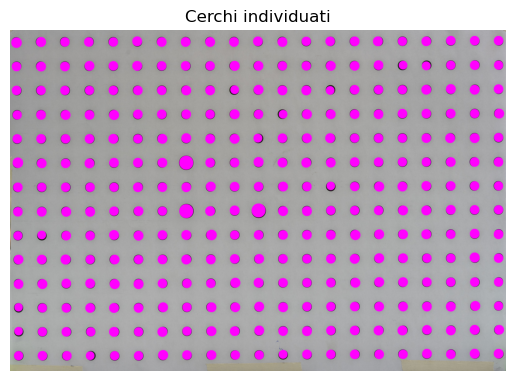

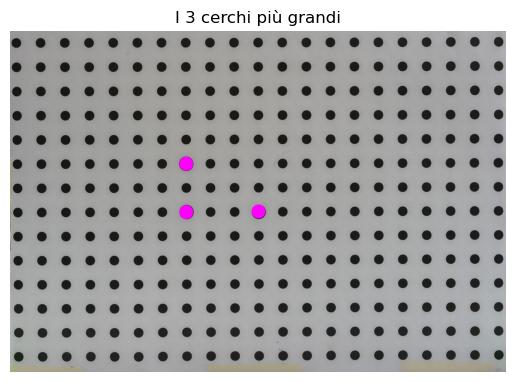

In [4]:
sz = h*w
minDistance=113
minRadius=16 #raggio minimo
maxRadius=86 #raggio massimo

circles = cv.HoughCircles( imgBIN, cv.HOUGH_GRADIENT, 8, minDist=minDistance, minRadius=minRadius, maxRadius=maxRadius, param1=140, param2=90 )
cdst = rgb.copy()
if circles is not None:
    print( f"Sono stati torvati {len(circles[0, :])} cerchi su {M*N}.")
    circles = np.uint16(np.around(circles))
for i in circles[0, :]:
    center = (i[0], i[1])
    #cv.circle(cdst, center, 1, (0, 100, 100), -1)
    radius = i[2]
    cv.circle(cdst, center, radius, (255, 0, 255), -1)
fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title( "Cerchi individuati" )
ax.axis('off')
circles[:,:,2]


#ordinare i cerchi in base al loro raggio
circles2=circles[0,:,:]
circles2=circles2[circles2[:,2].argsort()]
#salvo i 3 cerchi con raggio piu grande
circles3=circles2[-3:,:]
#stampo l'immagine con i 3 cerchi piu grandi
cdst3 = rgb.copy()
for i in circles3:
    center = (i[0], i[1])
    radius = i[2]
    cv.circle(cdst3, center, radius, (255, 0, 255), -1)
fig, ax = plt.subplots()
ax.imshow( cdst3 )
ax.set_title( "I 3 cerchi più grandi" )
ax.axis('off')


# Ricerca dei target circolari

L'uso di `findCirclesGrid` può semplificare notevolmente il processo di calibrazione della telecamera, poiché automatizza la localizzazione dei marcatori di riferimento necessari per il calcolo dei parametri di proiezione. In questo modo, è possibile ridurre al minimo gli errori manuali e aumentare la precisione e l'efficienza del processo di calibrazione.
La funzione `findCirclesGrid` è una funzione della libreria OpenCV utilizzata per identificare i pattern di cerchi in un'immagine.

Ecco come si usa:

```python
retval, centers = cv2.findCirclesGrid(image, patternSize[, centers[, flags[, blobDetector]]])
```

Parametri:

- `image`: L'immagine in cui cercare il pattern di cerchi.
- `patternSize`: Il numero di cerchi per riga e colonna (es. (rows, columns)).
- `centers` (opzionale): Questo è un output che restituisce le coordinate dei centri dei cerchi trovati.
- `flags` (opzionale): Questi parametri modificano il modo in cui la funzione cerca i cerchi. Alcuni esempi includono `cv2.CALIB_CB_SYMMETRIC_GRID`, `cv2.CALIB_CB_ASYMMETRIC_GRID`, e `cv2.CALIB_CB_CLUSTERING`.
- `blobDetector` (opzionale): Un oggetto `cv2.SimpleBlobDetector` che è utilizzato per rilevare i cerchi.

La funzione restituisce un valore booleano `retval` che indica se è stato trovato un pattern valido, e `centers` che è un array di coordinate dei centri dei cerchi trovati.


Sono stati torvati 294 cerchi su 294.


Text(0.5, 1.0, 'Cerchi individuati')

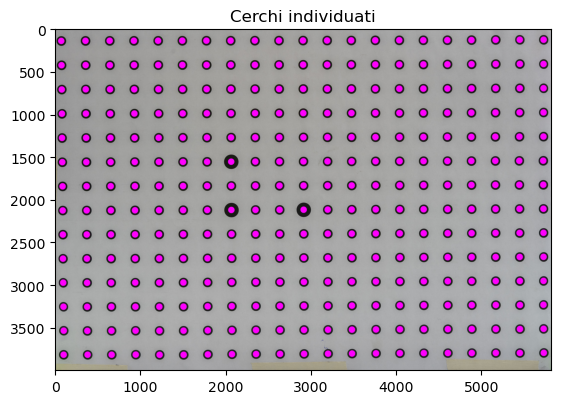

In [5]:
pattern = (M,N)
# è utile ridurre le dimensioni dell'immagine, questo codice calcola le nuove dimensioni mantenendo l'aspetto originale
scale_percent = 40  # percentuale di scala originale
width = int(imgBIN.shape[1] * scale_percent / 100)
height = int(imgBIN.shape[0] * scale_percent / 100)
dim = (width, height)

# Ridimensiona l'immagine
resized = cv.resize(imgBIN, dim, interpolation = cv.INTER_AREA)
ret, centers = cv.findCirclesGrid( resized, pattern, flags=cv.CALIB_CB_SYMMETRIC_GRID )
scale_ratio = 1 / (scale_percent / 100)
# Ridimensiona le coordinate dei centri dei cerchi
centers = centers * scale_ratio

if centers is not None:
    print( f"Sono stati torvati {len(centers)} cerchi su {M*N}.")
else:
    print( "Nessun cerchio trovato!" )
cdst = rgb.copy()
if centers is not None: 
    for center in centers:
        cv.circle( cdst, center[0].astype('int16'), int(w/150), (255,0,255), -1 )

fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title( "Cerchi individuati" )

# Trovo i 3 marker grandi
Le coordinate dei centri generati dal metodo `findCirclesGrid` sono più accurate rispetto a quelle generate da `HoughCircles` che però riesce anche a riconoscere il raggio dei cerchi.
Dovremo allora capire quali coordinate corrispondono tra i due metodi in modo da trovare `0,y,x` nella matrice generata da `findCirclesGrid`.

Per farlo dovremo anche calolare la distanza reciproca tra i diversi marker grandi.

array([[ 2916,  2116,  1013],
       [ 2068,  1556, 25582],
       [ 2068,  2124, 65256]], dtype=uint16)

array([[2069.9395, 2122.8447]], dtype=float32)

array([ 2068,  2124, 65256], dtype=uint16)

155

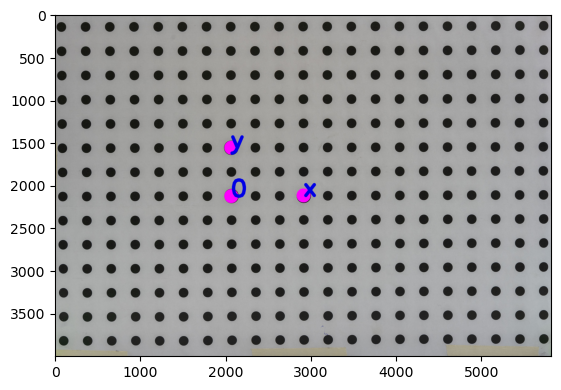

In [6]:
#Calcolo della distanza reciproca tra i 3 cerchi più grandi
for i in circles3:
    distanza=0
    for j in circles3:
        #solo se j e i sono diversi
        if i[0]!=j[0] or i[1]!=j[1]:
            #calcola la distanza tra i due cerchi
            distanza = np.linalg.norm(np.array([i[0], i[1]]) - np.array([j[0], j[1]])) + distanza
    #salva distanza in circle3 come terzo elemento
    i[2]=distanza

#ordina i cerchi in base alla distanza
circles3=circles3[circles3[:,2].argsort()]

arr = []
arr.append("x")
arr.append("y")
arr.append("0")
indice=0

for i in circles3:
    center = (i[0], i[1])
    #stampa la coordinata dell'asse rappresentato dal punto
    cv.putText(cdst3, str(arr[indice]), center, cv.FONT_HERSHEY_SIMPLEX, int(w/600), (0, 0, 230), int(w/150), cv.LINE_AA)
    indice=indice+1

fig, ax = plt.subplots()
ax.imshow( cdst3 )
display(circles3)

#Trovo l'indice del centroide
bestDistance=1000
k=0
temp=0
for i in centers:
    #calcola la distanza tra i due cerchi
    temp=temp+1
    distanza=np.sqrt((i[0][0]-circles3[2][0])**2+(i[0][1]-circles3[2][1])**2)
    if bestDistance>distanza:
        k=temp
        bestDistance=distanza
        bestCenter=i

display(bestCenter)
display(circles3[2])
display(k)

# Camera Calibration 

La funzione `calibrateCamera` è una funzione della libreria OpenCV utilizzata per calibrare la camera. Questa funzione stima i parametri intrinseci e extrinseci della camera.

Ecco come si usa:

```python
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]])
```

Parametri:

- `objectPoints`: Un array di punti nell'oggetto di riferimento. Questo è solitamente un array di punti 3D reali che corrispondono ai punti nell'immagine.
- `imagePoints`: Un array di punti corrispondenti nell'immagine. Questi sono solitamente punti 2D nell'immagine che corrispondono ai punti dell'oggetto.
- `imageSize`: La dimensione dell'immagine utilizzata per la calibrazione.
- `cameraMatrix` (opzionale): Una matrice 3x3 che rappresenta i parametri intrinseci della camera.
- `distCoeffs` (opzionale): I coefficienti di distorsione della camera.
- `rvecs` e `tvecs` (opzionali): I vettori di rotazione e traslazione tra i sistemi di coordinate dell'oggetto e dell'immagine.
- `flags` (opzionale): Questi parametri modificano il modo in cui la funzione calibra la camera.
- `criteria` (opzionale): I criteri per l'ottimizzazione dell'algoritmo di calibrazione.

La funzione restituisce:

- `retval`: Un singolo valore di errore di riproiezione.
- `cameraMatrix`: La matrice della camera con i parametri intrinseci ottimizzati.
- `distCoeffs`: I coefficienti di distorsione ottimizzati.
- `rvecs`: I vettori di rotazione per ogni combinazione di punti dell'oggetto e dell'immagine.
- `tvecs`: I vettori di traslazione per ogni combinazione di punti dell'oggetto e dell'immagine.

In [7]:
objp = np.zeros((M*N,3), np.float32)

objp[:,:2] = np.mgrid[0:M,0:N].T.reshape(-1,2)
objk=objp[k]
display(objk)

objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

if centers is not None:
    objpoints.append( (objp - objk) * DISTANZAMM)
    imgpoints.append( centers )
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

    #display( cameraMatrix )
    #display( distCoeffs )

array([8., 7., 0.], dtype=float32)

array([[2.18893008e+04, 0.00000000e+00, 2.50310544e+03],
       [0.00000000e+00, 2.19089199e+04, 2.96616049e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

Errore totale: 0.08444860920273223
Percentuale area foto scartata: 0.69


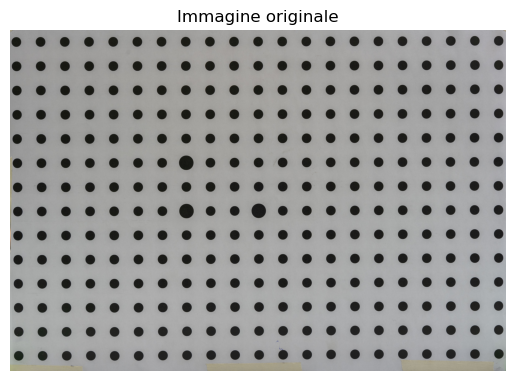

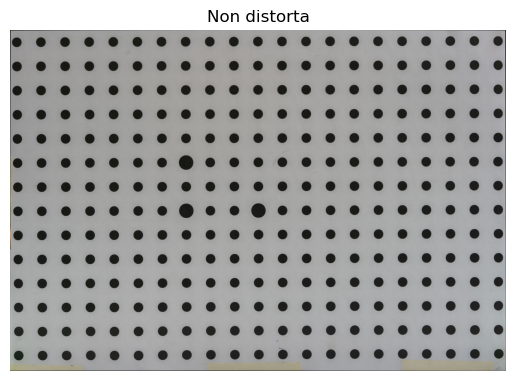

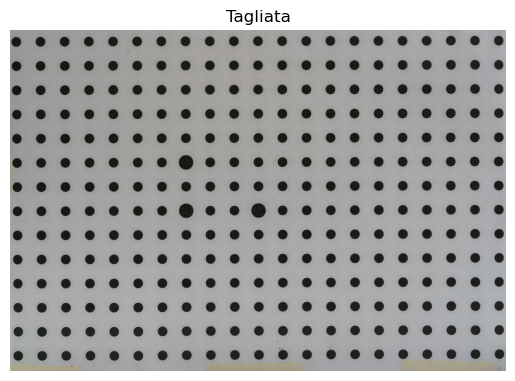

In [8]:
newcameramtx, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w,h), 1, (w,h))
display(newcameramtx)
img2 = rgb.copy()
hold, wold, _ = img2.shape
#undistort the image
undistorted = cv.undistort(img2, cameraMatrix, distCoeffs, None, newcameramtx)

#Crop the image
x, y, w, h = roi
cropped = undistorted[y:y+h, x:x+w]

# prova copia immagine cropped per test calibrazione
prova1 = cropped.copy()
prova1 = cv.cvtColor(prova1,cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots()
ax.imshow( img2, cmap='gray' )
ax.axis('off')
ax.set_title( "Immagine originale" )

fig, ax = plt.subplots()
ax.imshow( undistorted )
ax.axis('off')
ax.set_title( "Non distorta" )

fig, ax = plt.subplots()
ax.imshow( cropped )
ax.axis('off')
ax.set_title( "Tagliata" )

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, distCoeffs)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "Errore totale: {}".format(mean_error/len(objpoints)) )  #cos'è questo errore????
percentage = 100 - ((((w - x) * (h - y)) / (hold * wold)) * 100)
rounded_percentage = round(percentage, 2)
print("Percentuale area foto scartata: {}".format(rounded_percentage))
h, w, _ = cropped.shape

# Devo ritorvare tutti i punti dell'immagine non distorta
1. Contrasto
2. Binarizzazione
3. Find circleGrid

(-0.5, 5805.5, 3990.5, -0.5)

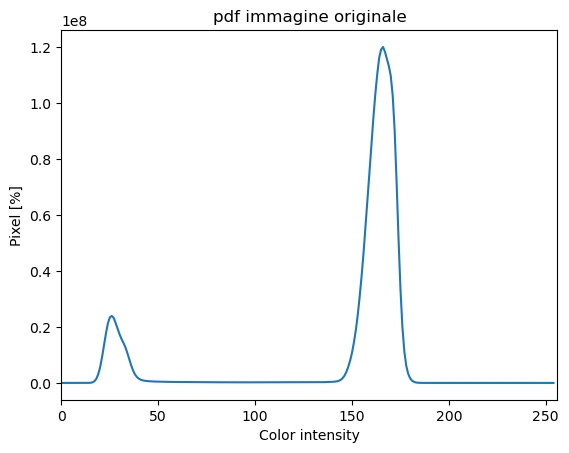

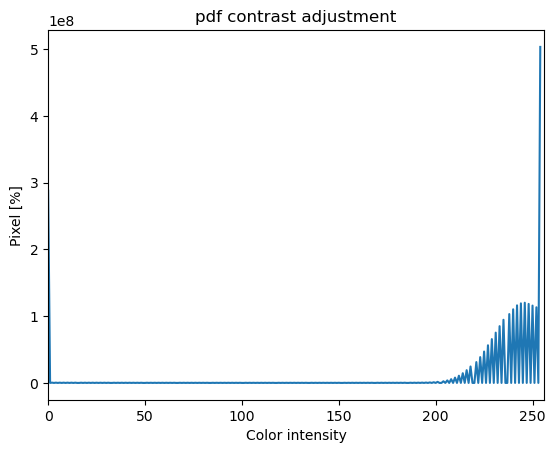

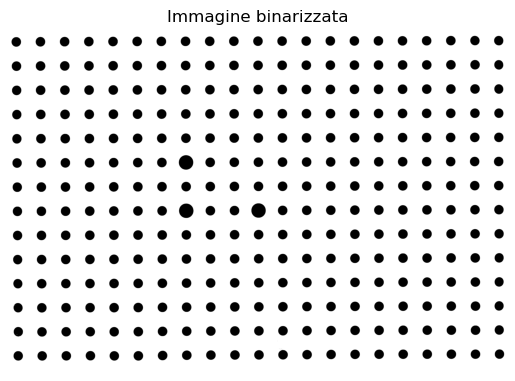

In [9]:
img2 = cv.cvtColor( cropped, cv.COLOR_BGR2GRAY ) 
pdf = np.histogram( img2, bins=range(256) )[0]/1*100
#Plot 1 - Histogram pdf
fig, ax = plt.subplots()
ax.plot( pdf )
ax.set_title( "pdf immagine originale" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

imgContrastAdjust = np.frompyfunc( lambda x: contrastAdjust(x, thLow, thHigh), 1, 1)
imgCA = imgContrastAdjust(img2).astype('uint8')

pdf2 = np.histogram( imgCA, bins=range(256) )[0]/1*100
fig, ax = plt.subplots()
ax.plot( pdf2 )
ax.set_title( "pdf contrast adjustment" )
ax.set_xlim( [0,256] )
ax.set_xlabel( "Color intensity" )
ax.set_ylabel( "Pixel [%]")

#eseguo la binarizzazione dell'immagine
ret2, imgBIN = cv.threshold( imgCA, thLowBin, thHighBin, cv.THRESH_BINARY )
fig, ax = plt.subplots()
ax.imshow( imgBIN, cmap='gray' )
ax.set_title( "Immagine binarizzata" )
ax.axis('off')

Sono stati torvati 294 cerchi su 294.


Text(0.5, 1.0, 'Cerchi individuati')

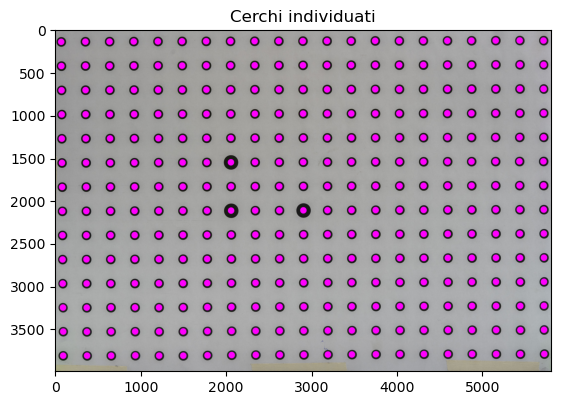

In [10]:
rgb=cropped
pattern = (M,N)
# è utile ridurre le dimensioni dell'immagine, questo codice calcola le nuove dimensioni mantenendo l'aspetto originale
scale_percent = 40  # percentuale di scala originale
width = int(imgBIN.shape[1] * scale_percent / 100)
height = int(imgBIN.shape[0] * scale_percent / 100)
dim = (width, height)

# Ridimensiona l'immagine
resized = cv.resize(imgBIN, dim, interpolation = cv.INTER_AREA)
ret, centers = cv.findCirclesGrid( resized, pattern, flags=cv.CALIB_CB_SYMMETRIC_GRID )
scale_ratio = 1 / (scale_percent / 100)
# Ridimensiona le coordinate dei centri dei cerchi
centers = centers * scale_ratio

if centers is not None:
    print( f"Sono stati torvati {len(centers)} cerchi su {M*N}.")
else:
    print( "Nessun cerchio trovato!" )
cdst = rgb.copy()
if centers is not None: 
    for center in centers:
        cv.circle( cdst, center[0].astype('int16'), int(w/150), (255,0,255), -1 )

fig, ax = plt.subplots()
ax.imshow( cdst )
ax.set_title( "Cerchi individuati" )

In [11]:
# Object Points 
objpts = np.zeros((M*N,3), np.float32)
objpts[:,:2] = np.mgrid[0:M,0:N].T.reshape(-1,2)
objpts[:] = objpts[:] - objpts[k,:]
objpts[:,0] = objpts[:,0]*deltaX
objpts[:,1] = -1*objpts[:,1]*deltaY
objpts[:,2] = 0


# # Image Points
# imgpts = centers

#---------------- Punti Immagine -------------------------------
imgpts = centers
objpoints = [] # Coordinate nel sistema di riferimento globale
imgpoints = [] # Coordinate nel sistema di riferimento immagine 
objpoints.append( objpts )
imgpoints.append( centers )

#-------------- Creo i nuovi array dei punti oggetto e dei punti immagine ----------------
imgpts_new = [] # Punti usati per calibrare la camera
objpts_new = [] # Punti usati per per calibrare la camera
imgpts_test = [] # Punti usati per verificare la calibrazione
objpts_test = [] # Punti usati per verificare la calibrazione        
j=0
l=1
for i in range(int(len(imgpts)/2)):
    imgpts_new.append(imgpts[j])
    objpts_new.append(objpts[j])
    imgpts_test.append(imgpts[l])
    objpts_test.append(objpts[l])
    j+=2
    l+=2
imgpts_new = np.array(imgpts_new)
objpts_new = np.array(objpts_new)
#----------------------------------------------------------------------------------------------


In [15]:
Q = []
d = []
for i in range( objpts.shape[0] ):
    op = objpts[i]   #[x_sg, y_sg, z_sg]
    ip = imgpts[i][0]

    i_s = ip[0]
    j_s = ip[1]

    Q.append(np.concatenate( [op, [1,0,0,0,0], -1*op*i_s] ))
    Q.append(np.concatenate( [[0,0,0,0], op, [1], -1*op*j_s]))
    
    d.append( i_s )
    d.append( j_s )

Q=np.array(Q)
d=np.array(d)


m = np.dot( np.linalg.pinv( Q ), d )
gamma2 = m[8]**2 + m[9]**2 + m[10]**2
tz = np.sqrt( 1/gamma2 )
P = np.reshape( np.concatenate( [m,[1]] )*tz, (3,4) )

print( f"Matrice P:\n {P} \n" )
print( f"Vettore m:\n {m} \n" )
M_vet = m.reshape(-1)

# aggiunte variabili m più comode (vedi dopo)
m1=m[0]
m2=m[1]
m3=m[2]
m4=m[3]
m5=m[4]
m6=m[5]
m7=m[6]
m8=m[7]
m9=m[8]
m10=m[9]
m11=m[10]

Matrice P:
 [[ 1.00484905e+06 -5.94098674e+03  7.18941963e-04  1.66732190e+08]
 [-2.42434042e+03 -1.00672541e+06 -3.71843435e-08  1.50278626e+08]
 [ 5.37949775e-01 -8.42976891e-01  0.00000000e+00  7.11527861e+04]] 

Vettore m:
 [ 1.41224132e+01 -8.34961926e-02  1.01041997e-08  2.34329813e+03
 -3.40723189e-02 -1.41487842e+01 -5.22598559e-13  2.11205540e+03
  7.56048785e-06 -1.18474193e-05  0.00000000e+00] 



# Verifica della claibrazione

Risultati Verifica calibrazione Riferimento Globale -> Coordinate Immagine
Ei= 1853.131159934022
Ej= 1853.1144957025745
sigmai= 1286.4786192442166
sigmaj= 1286.484497676816

Risultati Coordinate Immagine -> Sistema di riferimento Globale
Ex= 131.96606798476193
Ey= 130.8370421371873
sigmax= 91.64531895997328
sigmay= 90.87681248305536


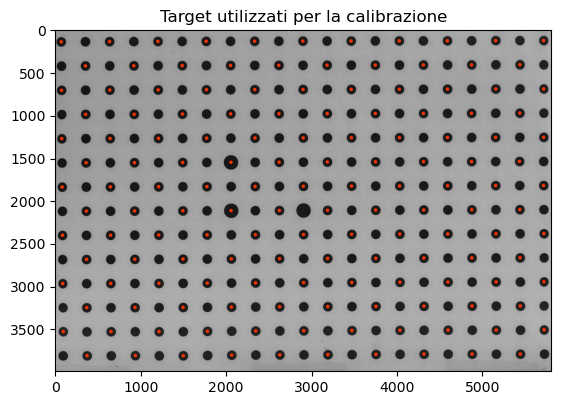

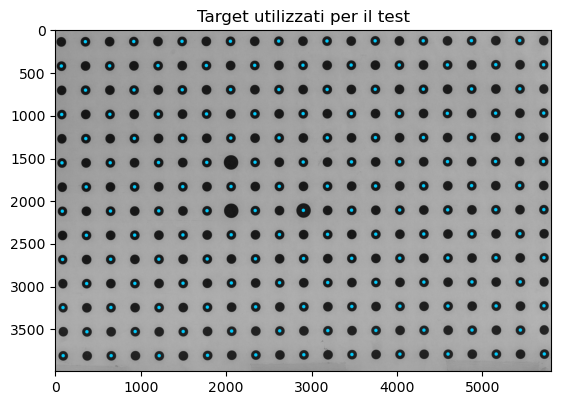

In [16]:
punti_immagine_calcolati = []
scarto = []
for i in range(len(objpts_test)):
    IJK = np.dot(P,np.append(objpts_test[i],1))
    IJ = (IJK/IJK[2])[0:2]
    punti_immagine_calcolati.append(IJ[::-1])
    scarto.append(abs(IJ[::-1]-imgpts_test[i]))
punti_immagine_calcolati = np.array(punti_immagine_calcolati)
scarto = np.array(scarto)

Ei = scarto[:,0,0].mean()
Ej = scarto[:,0,1].mean()
sigmai = scarto[:,0,0].std()
sigmaj = scarto[:,0,1].std()
print("Risultati Verifica calibrazione Riferimento Globale -> Coordinate Immagine")
print( f"Ei= {Ei}" )
print( f"Ej= {Ej}" )
print( f"sigmai= {sigmai}" )
print( f"sigmaj= {sigmaj}" )

#Verifica calibrazione coordinate immagine -> coordinate globali

objpts_test = np.array(objpts_test)
coordinate_globali_calcolate = []
scarto_x = []
scarto_y = []


for i in range(len(imgpts_test)):
    i_pts=imgpts_test[i][0][1]
    j_pts=imgpts_test[i][0][0]
    A=np.zeros([2,2])
    b=np.zeros([2,1])
    A[0,0]=m1-m9*i_pts
    A[0,1]=m2-m10*i_pts
    A[1,0]=m5-m9*j_pts
    A[1,1]=m6-m10*j_pts
    
    b[0,0]=i_pts-m4
    b[1,0]=j_pts-m8
    XY=np.linalg.solve(A,b)
    coordinate_globali_calcolate.append(XY)
    scarto_x.append(abs(XY[0]-objpts_test[i][0]))
    scarto_y.append(abs(XY[1]-objpts_test[i][1]))
    
coordinate_globali_calcolate = np.array(coordinate_globali_calcolate)
scarto_x = np.array(scarto_x)
scarto_y = np.array(scarto_y)

Ex = scarto_x.mean()
Ey = scarto_y.mean()
sigmax = scarto_x.std()
sigmay = scarto_y.std()
print("\nRisultati Coordinate Immagine -> Sistema di riferimento Globale")
print( f"Ex= {Ex}" )
print( f"Ey= {Ey}" )
print( f"sigmax= {sigmax}" )
print( f"sigmay= {sigmay}" )

# cambiato image -> resized. cerco l'immagine corretta da convertire in scala di grigi
cdst = cv.cvtColor( prova1, cv.COLOR_GRAY2RGB )
for center in imgpts_new:
    cv.circle( cdst, center[0].astype('int16'), 20, (255,50,0), -1 )
    
plt.imshow( cdst)
plt.title("Target utilizzati per la calibrazione")
plt.show()

# cambiato image -> resized. cerco l'immagine corretta da convertire in scala di grigi
cdst = cv.cvtColor( prova1, cv.COLOR_GRAY2RGB )
for center in imgpts_test:
    cv.circle( cdst, center[0].astype('int16'), 20, (0,205,255), -1 )


plt.imshow( cdst)
plt.title("Target utilizzati per il test")
plt.show()


# Calizbrazione lama di luce dal piano 0 e tutti gli altri piani

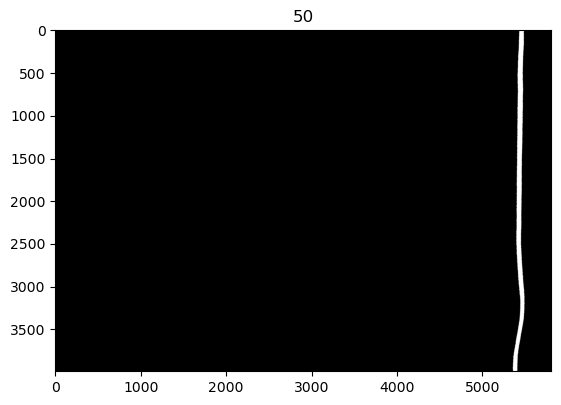

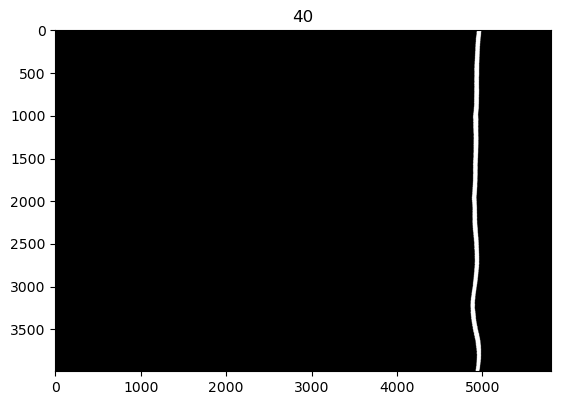

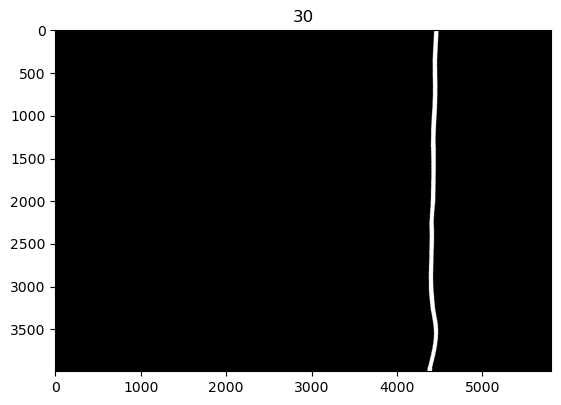

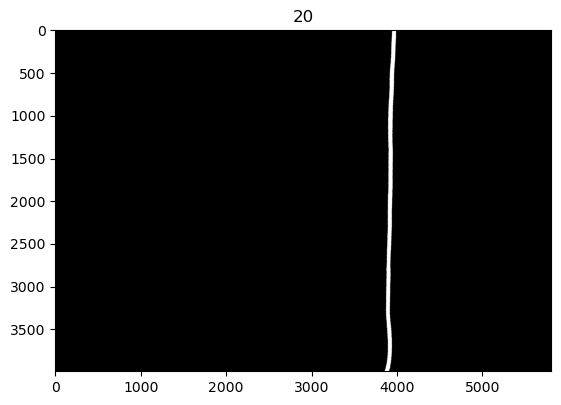

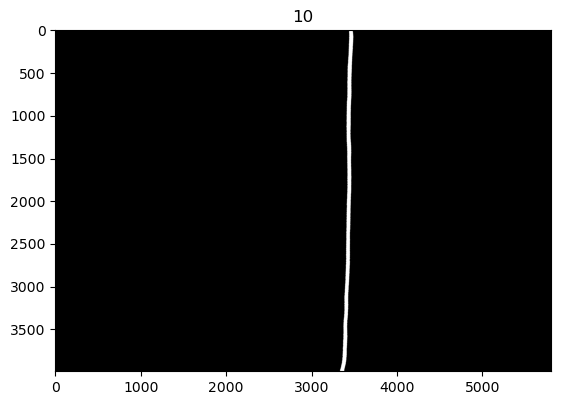

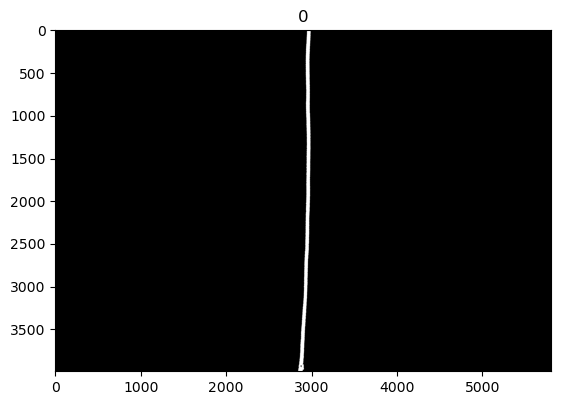

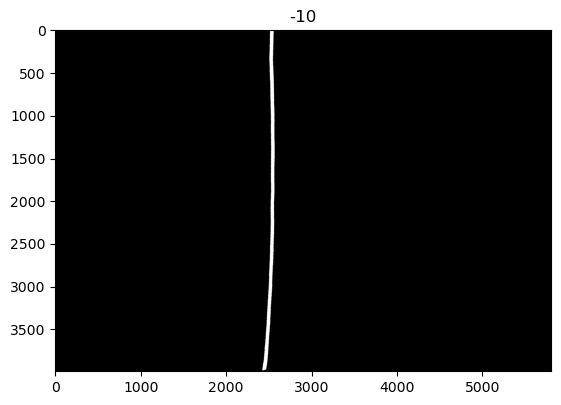

c:\Users\user\Desktop\Gli_Sprogrammatori\OpenCV1\.conda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\user\Desktop\Gli_Sprogrammatori\OpenCV1\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


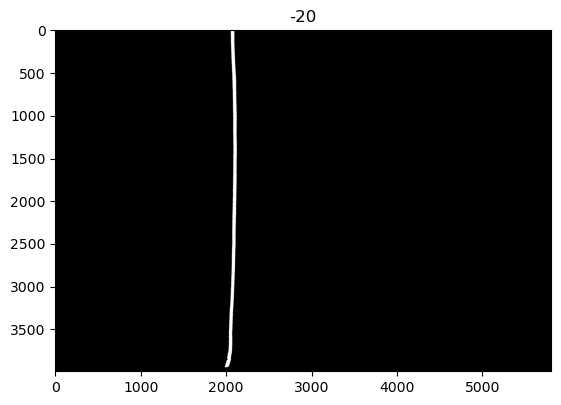

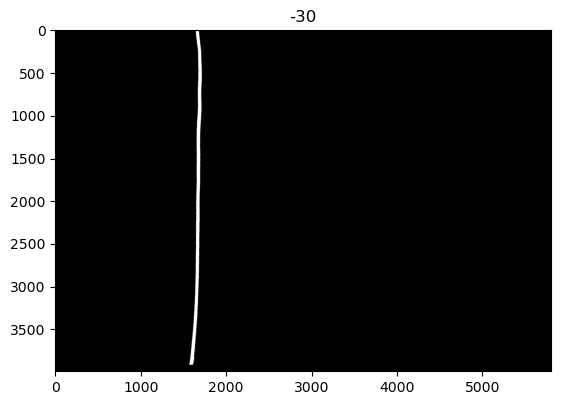

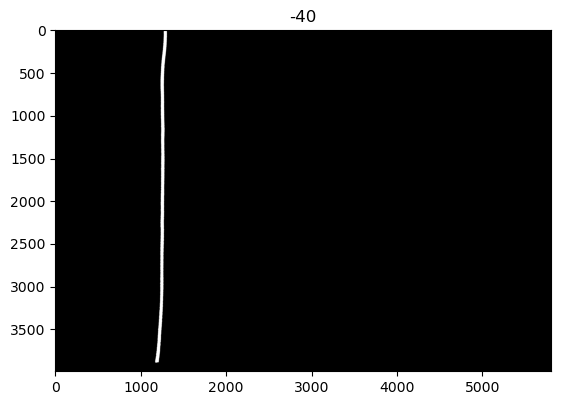

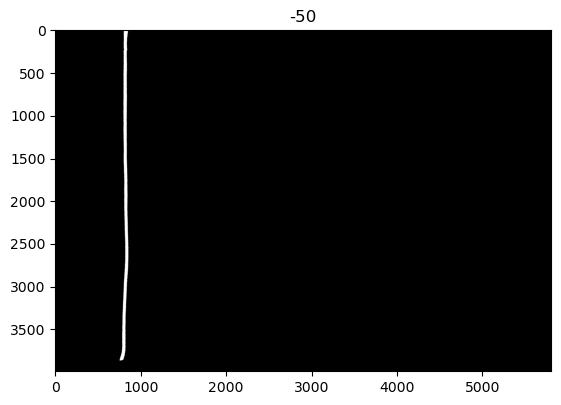

0.021658787083546804


In [17]:
IMG = []  # Lista per immagini
count = 0  # Contatore
Is = []  # Lista per coordinate x
Js = []  # Lista per coordinate y
Zsg = []  # Lista per coordinate z
Bar_lama = []  # Lista per punti sulla lama
Bar_lama_test = []  # Lista per punti sulla lama di test
punti_per_piano = 11  # Numero di punti per piano

temp_v=[]
# Iterazione su I
for i in I:
    zsg = ZSGVero - i
    img = cv.imread(os.path.join(IMGDIR, IMGNAMECALIB + str(i) + '.jpg'), cv.IMREAD_COLOR)
    assert img is not None, "ERRORE: File NON TROVATO!"
    
    #undistort the image
    undistortedL = cv.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)

    #Crop the image
    x, y, w, h = roi
    img = undistortedL[y:y+h, x:x+w]
    IMG.append(img)

    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    _, binary = cv.threshold(gray, 30, 255, cv.THRESH_BINARY)

    plt.imshow(binary,cmap='gray')
    plt.title(zsg)
    plt.show()

    h, w = binary.shape

    baricentri = []  # Vettore di zero lungo quanto l'altezza dell'immagine
    for j in range(h):
        baricentri.append([j,np.nanmean( np.where( binary[j,:] != 0 ) )])  # Inserisce nel vettore "baricentri" la media dei valori di grigio diversi da zero presenti nella riga j
    
    baricentri = np.array(baricentri)
    temp = np.nanmean(baricentri[:, 1])
    temp_v.append([temp, zsg])
    

    contatore1 = 0
    contatore2 = 10
    incremento = int( h/punti_per_piano )
    baricentri_temp1 = []
    baricentri_temp2 = []

    
    for k in range( punti_per_piano ):
        baricentri_temp1.append( baricentri[contatore1] )
        baricentri_temp2.append( baricentri[contatore2] )
        contatore1 += incremento
        contatore2 += incremento
    
    

    Bar_lama_test.append( baricentri_temp2 )
    Bar_lama.append( baricentri_temp1 )

temp_v = np.array(temp_v)
average_diff_z = np.mean(np.abs(np.diff(temp_v[:, 1])))
average_diff_pixel = np.mean(np.abs(np.diff(temp_v[:, 0])))
sensibilita_setup=average_diff_z/average_diff_pixel
print(sensibilita_setup)
#print(temp_v)

Bar_lama_test=np.concatenate(Bar_lama_test).reshape(-1,2)
#Bar_lama_test = np.array(Bar_lama_test)


In [22]:
# AGGIUNTO DAMIO

# implementazione verifica calibrazione lama da ultimo codice

numeroPunti = 0

for i in range( len(Bar_lama) ):
    numeroPunti += len( Bar_lama[i] )
xy = np.zeros([numeroPunti,3])
z = np.zeros([numeroPunti,1])

cont=0

for i in range(len(Bar_lama)):
   
    for j in range(len(Bar_lama[i])):
        
        i_s = Bar_lama[i][j][0]
        j_s = Bar_lama[i][j][1]
        
        A=np.zeros([2,2])
        b=np.zeros([2,1])

        A[0,0] = m[0]-m[8]*i_s
        A[0,1] = m[1]-m[9]*i_s
        A[1,0] = m[4]-m[8]*j_s
        A[1,1] = m[5]-m[9]*j_s
       
        b[0,0] = Bar_lama[i][j][0]-(m[2]-m[10]*i_s)*(ZSGVero-I[i])-m[3]
        b[1,0] = Bar_lama[i][j][1]-(m[6]-m[10]*j_s)*(ZSGVero-I[i])-m[7]

        x=np.linalg.solve(A,b)

        xy[cont,0]=x[0][0]
        xy[cont,1]=x[1][0]
        xy[cont,2]=1
        z[cont]=(ZSGVero-I[i])
        cont+=1

# print( f"xy= {xy}\n" )
# print( f"z= {z}\n" )
        
coeff_piano, res, rank, sing = np.linalg.lstsq( xy, z ,rcond = None)

A=coeff_piano[0][0]
B=coeff_piano[1][0]
C=coeff_piano[2][0]
print("Coefficienti del piano della lama di luce:\n")
print( f"A= {A}\n" )
print( f"B= {B}\n" )
print( f"C= {C}\n" )


Coefficienti del piano della lama di luce:

A= 0.0018479427379411242

B= -0.30574051340416303

C= -20.117441857916653



In [19]:
# AGGIUNTO DAMIO

# VERIFICA CALIBRAZIONE LAMA

z = []
y = []
x = []

for element in Bar_lama_test:
    
    i_s = element[0]
    j_s = element[1]
    
    H=np.zeros([3,3])
    b=np.zeros([3,1])

    H[0,0] = m[0]-m[8]*i_s
    H[0,1] = m[1]-m[9]*i_s
    H[0,2] = m[2]-m[10]*i_s

    H[1,0] = m[4]-m[8]*j_s
    H[1,1] = m[5]-m[9]*j_s
    H[1,2] = m[6]-m[10]*j_s

    H[2,0] = A
    H[2,1] = B
    H[2,2] = -1     

    b[0,0] = i_s-m[3]
    b[1,0] = j_s-m[7]
    b[2,0] = -C
            
    risultati = np.linalg.solve(H,b)

    x.append(risultati[0])
    y.append(risultati[1])
    z.append(risultati[2])
    
num_immagini=11
distanza_immagini = 10 #mm
errore=[]
#print(len(z))


for i in range(num_immagini):
    for j in range(punti_per_piano):
        errore.append(abs(z[i*distanza_immagini+j]-(ZSGVero - I[i])))


errore=np.array(errore)
errore_medio=np.mean(errore)
std=np.std(errore) #l'errore è in pixel?
formatted_erroreMedio = "{:.4f}".format(errore_medio)
formatted_std = "{:.4f}".format(std)
print( f"Errore medio: {formatted_erroreMedio} mm" )
print( f"Deviazione Standard: {formatted_std} mm" )

Errore medio: 525.6364 mm
Deviazione Standard: 60.7692 mm


# Misura

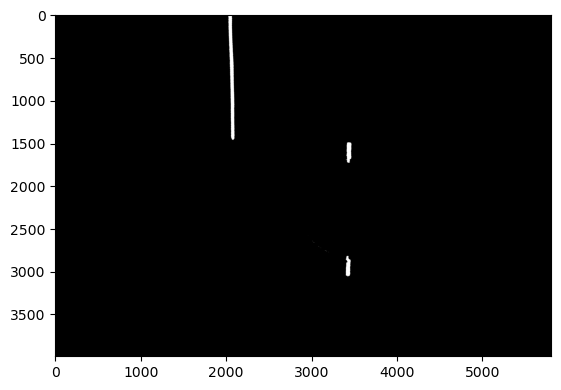

2421.918973326623


[]

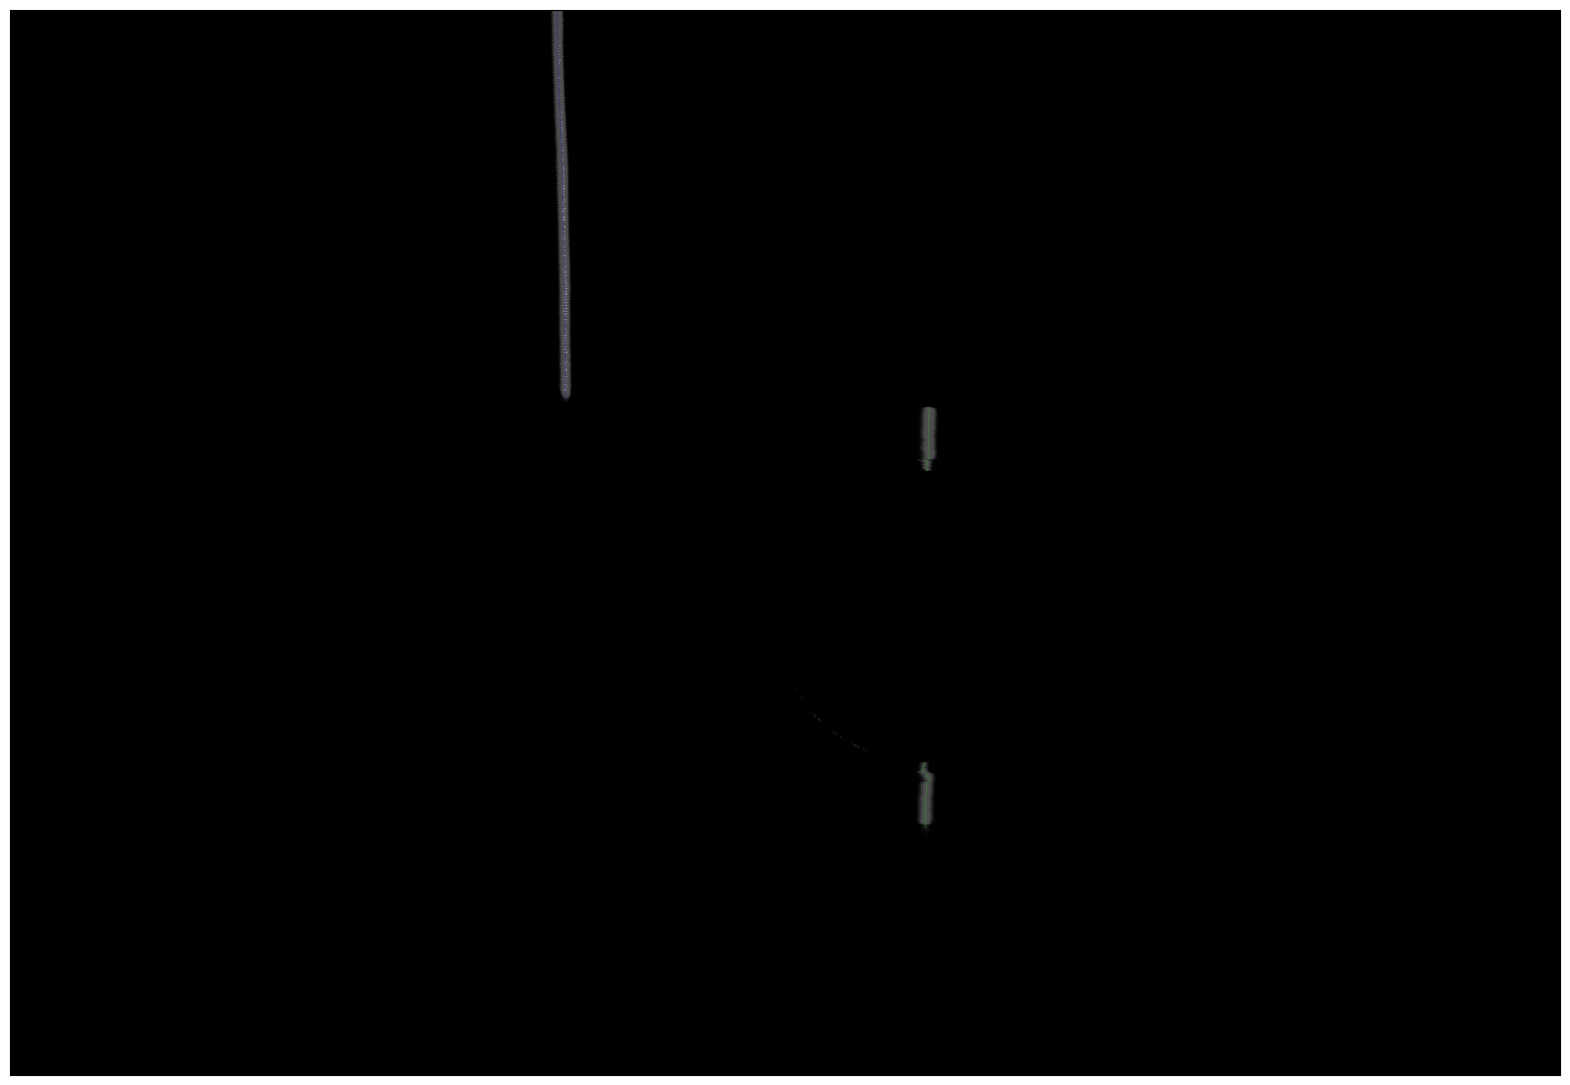

In [20]:
Bar_lama_f=[]

# Carica un'immagine dal percorso specificato
img = cv.imread(os.path.join( IMGDIR, 'Misure_05.jpg'), cv.IMREAD_COLOR )
assert img is not None, "ERROR: Immagine non trovata!"  

undistortedL = cv.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)

#Crop the image
x, y, w, h = roi
img = undistortedL[y:y+h, x:x+w]

# Converte l'immagine da BGR a RGB
rgb = cv.cvtColor( img, cv.COLOR_BGR2RGB ) 

# Converte l'immagine da BGR a scala di grigi
gray = cv.cvtColor( img, cv.COLOR_BGR2GRAY ) 

# Applica una soglia binaria all'immagine in scala di grigi
_,binary=cv.threshold(gray,30,255,cv.THRESH_BINARY)

# Ottiene le dimensioni dell'immagine binaria
h,w = binary.shape

# Visualizza l'immagine binaria
plt.imshow(binary,cmap='gray')
plt.show()

# Calcola la media dei valori dei pixel per ogni riga dell'immagine binaria
line = np.zeros( h )
for j in range( h ):
    line[j] = np.nanmean( np.where( binary[j,:] != 0 ) )

# Converte l'immagine in scala di grigi in un'immagine RGB
img = cv.cvtColor( gray, cv.COLOR_GRAY2RGB ) 

# Disegna una barra rossa sulla posizione media calcolata per ogni riga dell'immagine
for j in range( h ):
    if np.isnan(line[j])==False:
        i = int( line[j] )
        Bar_lama_f.append([i,j])
        img[j,i] = [255,0,0]

# Converte la lista delle posizioni delle barre in un array numpy
Bar_lama_f=np.array(Bar_lama_f)

# Individua la zona circolare calcolando la media delle posizioni verticali delle barre
pos_verticale_media=np.mean(Bar_lama_f[:,0])
print(pos_verticale_media)

# Divide le barre in due gruppi in base alla loro posizione verticale rispetto alla media
b_oggetto_s=[]
b_z_0=[]
for i in range(Bar_lama_f.shape[0]):
    if Bar_lama_f[i,0]>pos_verticale_media:
        b_oggetto_s.append(Bar_lama_f[i,:])
    else:
        b_z_0.append(Bar_lama_f[i,:])

# Converte le liste delle posizioni delle barre in array numpy
b_oggetto_s=np.array(b_oggetto_s)
b_z_0=np.array(b_z_0)

# Disegna le barre del gruppo "b_oggetto_s" in verde e le barre del gruppo "b_z_0" in blu sull'immagine
for i in range(b_oggetto_s.shape[0]):
    img[b_oggetto_s[i,1],b_oggetto_s[i,0]] = [0,255,0]
for i in range(b_z_0.shape[0]):
    img[b_z_0[i,1],b_z_0[i,0]] = [0,0,255]    

# Crea una figura e un'area di disegno per visualizzare l'immagine
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
ax.imshow( img )
ax.set_xticks([])
ax.set_yticks([])

In [21]:
# da controllare coeff_piano

def estrai_punti_oggetto(baric):
    
    z = []  
    y = []  
    x = []  

    for element in baric:
        H = np.zeros([3, 3])
        b = np.zeros([3, 1])

        # H matrix and b array configuration
        H[0, 0] = m[0] - m[8] * element[0]
        H[0, 1] = m[1] - m[9] * element[0]
        H[0, 2] = m[2] - m[10] * element[0]
        H[1, 0] = m[4] - m[8] * element[1]
        H[1, 1] = m[5] - m[9] * element[1]
        H[1, 2] = m[6] - m[10] * element[1]
        H[2, 0] = A
        H[2, 1] = B
        H[2, 2] = -1

        b[0, 0] = element[0] - m[3]
        b[1, 0] = element[1] - m[7]
        b[2, 0] = -C

        # Resolution of the system: Hx=b
        risultati = np.linalg.solve(H, b)

        x.append(risultati[0][0])
        y.append(risultati[1][0])
        z.append(risultati[2][0])

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    return x, y, z

# Calcolo h a z=0
x_rif1, y_rif1, z_rif1 = estrai_punti_oggetto(b_z_0)
H_0 = np.mean(z_rif1)  # Calcolo dell'altezza media a z=0

x_ogg1, y_ogg1, H_b_oggetto = estrai_punti_oggetto(b_oggetto_s)

H_max = np.max(H_b_oggetto)  # Calcolo dell'altezza massima dell'oggetto

display(z_rif1)  # Visualizzazione dell'altezza media a z=0
display(H_max)  # Visualizzazione dell'altezza massima dell'oggetto

risultato=[]
tempCont=0
i=0
for j in range( h ):
    if any(binary[j,:] != 0):
        if Bar_lama_f[i,0]>pos_verticale_media:
            risultato.append((H_b_oggetto[tempCont] - H_0)[0])
            tempCont=tempCont+1
        else:
            risultato.append(0)
        i=i+1
    else:
        risultato.append(0)

plt.plot(risultato)  # Grafico dell'altezza dell'oggetto rispetto all'altezza media a z=0
plt.xlabel('Index (pixel)')
plt.ylabel('Altezza (mm)')
plt.title('Forma oggetto misurato dalla lama di luce')
plt.show()

# inserire un index in mm nell'asse x
d = H_max - H_0  # Calcolo della differenza di altezza
print('Altezza massima oggetto misurato: '+str(round(d,2)) + 'mm')  # Stampa della differenza di altezza in millimetri
#La sensibilità di uno strumento è il più piccolo valore della grandezza che lo strumento può distinguere
print('Sensibilità del setup di misura: '+str(round(sensibilita_setup,4)) + 'mm')
#La portata di uno strumento è il più grande valore della grandezza che lo strumento può misurare
h, w, _ = img.shape
print('Portata del setup di misura: '+str(round(w*sensibilita_setup,2)) + 'mm')

array([595.8088719 , 595.78730521, 595.76573848, ..., 564.27629136,
       564.16859231, 564.14637203])

563.3561442568862

IndexError: invalid index to scalar variable.